In [4]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=9
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [7]:
# data wrangling: load Fashion-MNIST
EMNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


EMNIST_train = torchvision.datasets.EMNIST(
        '~/data/emnist',
        train=True,
        download=True,
        transform=EMNIST_transform,
        split = 'mnist')



EMNIST_test = torchvision.datasets.EMNIST(
        '~/data/emnist',
        train=False,
        download=False,
        transform=EMNIST_transform,
        split = 'mnist')


100.0%

Extracting /Users/moreez/data/emnist/EMNIST/raw/emnist.zip to /Users/moreez/data/emnist/EMNIST/raw
Processing byclass


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


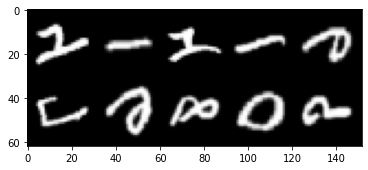

In [8]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = EMNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [16]:
emnist_train_loader = torch.utils.data.dataloader.DataLoader(
    EMNIST_train,
    batch_size=128,
    shuffle=True
)

emnist_test_loader = torch.utils.data.dataloader.DataLoader(
    EMNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [10]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [11]:
#set up the training routine
emnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

emnist_train_optimizer = torch.optim.Adam(emnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
EMNIST_PATH = "EMNIST_weights_seed={}.pth".format(s)
#print(FMNIST_PATH)

In [12]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [13]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(emnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(emnist_train_loader):
            output = emnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            emnist_train_optimizer.step()
            emnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(EMNIST_PATH))
    torch.save(emnist_model.state_dict(), EMNIST_PATH)

In [14]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


Iteration 0; 0/469 	Minibatch Loss 2.281  Accuracy 13%
Iteration 0; 10/469 	Minibatch Loss 1.871  Accuracy 50%
Iteration 0; 20/469 	Minibatch Loss 1.163  Accuracy 65%
Iteration 0; 30/469 	Minibatch Loss 0.601  Accuracy 84%
Iteration 0; 40/469 	Minibatch Loss 0.376  Accuracy 88%
Iteration 0; 50/469 	Minibatch Loss 0.399  Accuracy 90%
Iteration 0; 60/469 	Minibatch Loss 0.320  Accuracy 91%
Iteration 0; 70/469 	Minibatch Loss 0.227  Accuracy 93%
Iteration 0; 80/469 	Minibatch Loss 0.266  Accuracy 91%
Iteration 0; 90/469 	Minibatch Loss 0.183  Accuracy 95%
Iteration 0; 100/469 	Minibatch Loss 0.163  Accuracy 95%
Iteration 0; 110/469 	Minibatch Loss 0.141  Accuracy 97%
Iteration 0; 120/469 	Minibatch Loss 0.165  Accuracy 97%
Iteration 0; 130/469 	Minibatch Loss 0.175  Accuracy 95%
Iteration 0; 140/469 	Minibatch Loss 0.273  Accuracy 90%
Iteration 0; 150/469 	Minibatch Loss 0.295  Accuracy 91%
Iteration 0; 160/469 	Minibatch Loss 0.174  Accuracy 96%
Iteration 0; 170/469 	Minibatch Loss 0.115

Iteration 3; 40/469 	Minibatch Loss 0.024  Accuracy 100%
Iteration 3; 50/469 	Minibatch Loss 0.017  Accuracy 100%
Iteration 3; 60/469 	Minibatch Loss 0.042  Accuracy 98%
Iteration 3; 70/469 	Minibatch Loss 0.031  Accuracy 98%
Iteration 3; 80/469 	Minibatch Loss 0.105  Accuracy 95%
Iteration 3; 90/469 	Minibatch Loss 0.060  Accuracy 98%
Iteration 3; 100/469 	Minibatch Loss 0.046  Accuracy 99%
Iteration 3; 110/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 3; 120/469 	Minibatch Loss 0.030  Accuracy 98%
Iteration 3; 130/469 	Minibatch Loss 0.057  Accuracy 98%
Iteration 3; 140/469 	Minibatch Loss 0.066  Accuracy 99%
Iteration 3; 150/469 	Minibatch Loss 0.031  Accuracy 99%
Iteration 3; 160/469 	Minibatch Loss 0.028  Accuracy 98%
Iteration 3; 170/469 	Minibatch Loss 0.015  Accuracy 99%
Iteration 3; 180/469 	Minibatch Loss 0.036  Accuracy 99%
Iteration 3; 190/469 	Minibatch Loss 0.033  Accuracy 98%
Iteration 3; 200/469 	Minibatch Loss 0.052  Accuracy 98%
Iteration 3; 210/469 	Minibatch Los

In [17]:
#predict in distribution
EMNIST_PATH = "EMNIST_weights_seed={}.pth".format(s)

emnist_model = NN(num_classes=10)
print("loading model from: {}".format(EMNIST_PATH))
emnist_model.load_state_dict(torch.load(EMNIST_PATH))
emnist_model.eval()

acc = []

max_len = len(emnist_test_loader)
for batch_idx, (x, y) in enumerate(emnist_test_loader):
        output = emnist_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on EMNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: EMNIST_weights_seed=9.pth
Batch 0/79 	Accuracy 99%
Batch 10/79 	Accuracy 98%
Batch 20/79 	Accuracy 99%
Batch 30/79 	Accuracy 100%
Batch 40/79 	Accuracy 100%
Batch 50/79 	Accuracy 100%
Batch 60/79 	Accuracy 99%
Batch 70/79 	Accuracy 99%
overall test accuracy on EMNIST: 98.88 %


# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [18]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [19]:
#EMNIST_NN_Std_prec_00001 = get_Hessian_NN(model=emnist_model, train_loader=emnist_train_loader, prec0=0.0001,verbose=False)
#torch.save(EMNIST_NN_Std_prec_00001, 'Hessian_prec00001_EMNIST.pth')

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([32, 32, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([10, 512])
parameter size:  torch.Size([10])


In [14]:
EMNIST_NN_Std_prec_00001 = torch.load('Hessian_prec00001_KMNIST.pth')

## Now we want to look at the single layers of our network, and how they behave w.r.t. the variance
* every tensor represents one of the six layers of out network


## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [27]:
import seaborn as sns
def visualize(tensor):
    output = tensor[0][0]
    for i in range(1, len(tensor[0])):
        output = np.concatenate((output, tensor[0][i]))
    output = output.transpose(2, 0, 1).reshape(5, -1)
    heatmap = sns.heatmap(output)
    plt.xticks = (np.arange(0, step=20))
    plt.show()
   

In [28]:
#visualize(MNIST_NN_Hessian_diag_10)

In [20]:
def meancalc(Hessian_diag_x):
    i = 0 
    for name, parameter in emnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean variance of layer {0:s}: {1:.4f}".format(name, mean.item()))
        i += 1
    


In [21]:
meancalc(Hessian_diag_x=EMNIST_NN_Std_prec_00001)

mean variance of layer 0.weight: 28.8430
mean variance of layer 0.bias: 14.0220
mean variance of layer 3.weight: 68.3540
mean variance of layer 3.bias: 40.1741
mean variance of layer 7.weight: 31.3387
mean variance of layer 7.bias: 26.6921


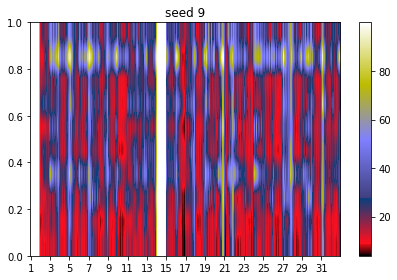

(array([[ 39., 143., 128.,  70.,  44.,  31.,  16.,   9.,   0.,  32.],
        [ 16.,  72.,  69.,  57.,  68.,  48.,  55.,  43.,  29.,  55.],
        [ 92., 227.,  94.,  33.,  15.,  11.,   7.,   1.,   0.,  32.],
        [ 83., 161., 109.,  64.,  28.,  14.,  15.,   3.,   2.,  33.],
        [114., 196.,  69.,  44.,  27.,  15.,  10.,   1.,   4.,  32.],
        [104., 205.,  93.,  37.,  21.,   7.,  11.,   2.,   0.,  32.],
        [ 33., 122., 137.,  67.,  44.,  37.,  20.,  11.,   9.,  32.],
        [ 97., 182.,  99.,  41.,  23.,  17.,  11.,   8.,   2.,  32.],
        [227., 157.,  47.,  18.,  15.,   8.,   5.,   3.,   0.,  32.],
        [238., 147.,  52.,  18.,  14.,   6.,   2.,   3.,   0.,  32.]]),
 array([ 3.865574 , 13.4790125, 23.092451 , 32.70589  , 42.31933  ,
        51.93277  , 61.546207 , 71.159645 , 80.77309  , 90.38652  ,
        99.99996  ], dtype=float32),
 <a list of 10 Lists of Patches objects>)

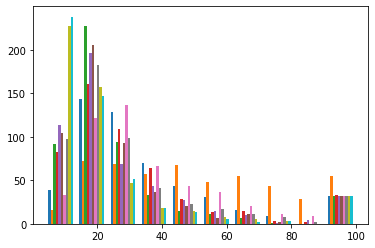

In [22]:
plt.imshow(EMNIST_NN_Std_prec_00001[4], cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
#plt.savefig('linear_seed1000={}'.format(s))

plt.hist(EMNIST_NN_Std_prec_00001[4])

In [32]:
"""
mnist_number = 9
linear_layer_index = 4 #linear layer has index 4
linear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))

#plot setup
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

#iterate through the features and plot them
for i in range(len(layer_split)):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))
    axs[i].imshow(layer_split[i])
    axs[i].set_title('feature '+str(i+1))
"""

"\nmnist_number = 9\nlinear_layer_index = 4 #linear layer has index 4\nlinear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]\n\n#reshape the flattened array to 32* (4x4)\nlayer_split = np.array_split(np.array(linear_layer), 32)\nfor i in range(len(layer_split)-1):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n\n#plot setup\nfig, axs = plt.subplots(4,8, figsize=(20, 15))\nfig.subplots_adjust(hspace = .001, wspace=.001)\naxs = axs.ravel()\n\n#iterate through the features and plot them\nfor i in range(len(layer_split)):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n    axs[i].imshow(layer_split[i])\n    axs[i].set_title('feature '+str(i+1))\n"

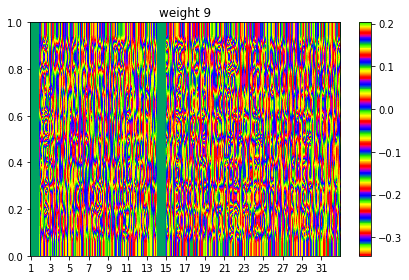

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 array([-0.34310922, -0.28849572, -0.23388223, -0.17926875, -0.12465526,
        -0.07004177, -0.01542828,  0.03918521,  0.0937987 ,  0.1484122 ,
         0.20302568], dtype=float32),
 <a list of 512 Lists of Patches objects>)

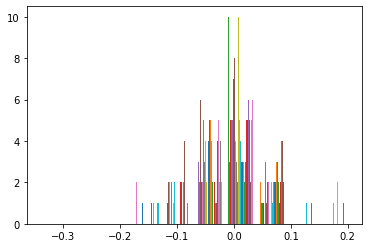

In [23]:
for name, parameters in emnist_model.named_parameters():
    if name == '7.weight':
        a = parameters

b = a.detach().numpy()

plt.imshow(b, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('weight {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
plt.hist(b)

(array([[ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  1.,  0.,  0., 14.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 13.,  2.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.]]),
 array([-1.4030835e-05, -1.1935416e-05, -9.8399987e-06, -7.7445802e-06,
        -5.6491617e-06, -3.5537437e-06, -1.4583254e-06,  6.3709274e-07,
         2.7325109e-06,  4.8279294e-06,  6.9233474e-06], dtype=float32),
 <a list of 10 Lists of Patches objects>)

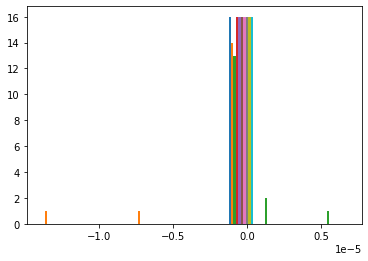

In [88]:
to_hist = []
target_feature = 9
for i in range(10):
    weight = a[i].detach().numpy()
    weight = np.array_split(np.array(weight), 32)
    to_hist.append(weight[target_feature -1])
plt.hist(to_hist)

In [87]:
"""
observe = [1, 8, 13, 14, 17, 24]
f,c = plt.subplots(3,2)
plt.figure(figsize=(20,20))
c = c.ravel()
for i in range(10):
    test = np.array_split(a[i].detach().numpy(), 32)
for idx, ax in enumerate(c):
    ax.set_title(str(observe[idx] +1))
    ax.hist(test[observe[idx]])
plt.tight_layout()
        
    
#for idx,ax in enumerate(a):
 #   ax.hist(test[observe[idx]])
 """

'\nobserve = [1, 8, 13, 14, 17, 24]\nf,c = plt.subplots(3,2)\nplt.figure(figsize=(20,20))\nc = c.ravel()\nfor i in range(10):\n    test = np.array_split(a[i].detach().numpy(), 32)\nfor idx, ax in enumerate(c):\n    ax.set_title(str(observe[idx] +1))\n    ax.hist(test[observe[idx]])\nplt.tight_layout()\n        \n    \n#for idx,ax in enumerate(a):\n #   ax.hist(test[observe[idx]])\n '